### Modeling

Model Training, Hyperparameter Tuning, and Evaluation

In [6]:
import os, subprocess
import pickle
import warnings
from tqdm import tqdm
from pprint import pprint

import pandas as pd
import numpy as np

# modeling/experimentation
import mlflow
import lightgbm as lgb
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# to load parameters of the experiments
from kedro.config import ConfigLoader

# utils
import multiprocessing as mp
from joblib import Parallel, delayed
from pandas import IndexSlice as idx
from IPython.display import display

# viz
import seaborn as sns
import shap
import matplotlib.pyplot as plt

# experiments
import experiments.noaa.machine_learning as ml_experiments

# local utils and other imports
from spatial_interpolation import data, utils
from spatial_interpolation.utils.modeling import (
    tweak_features,
    fit_estimator_with_params,
    compute_metrics,
)
from spatial_interpolation.utils.experiments import conf 
from spatial_interpolation.data.load_data import get_ml_workspace
from spatial_interpolation.utils import tqdm_joblib

# configuration
import dotenv
warnings.simplefilter(action='ignore', category=FutureWarning)
dotenv.load_dotenv()

True

In [3]:
# Track the experiment with MLFlow
# ws = data.get_ml_workspace(auth="service_principal")
# tracking_uri = ws.get_mlflow_tracking_uri()
# mlflow.set_tracking_uri(tracking_uri)
# mlflow.set_experiment(os.environ.get("MLFLOW_EXPERIMENT_NAME"))

In [7]:
# load features
config_name = "experiment4"
experiment = ml_experiments.NOAAMLTraining(config_name)#, mlflow_tracking_uri=tracking_uri)
config = experiment.get_config()

train_df = pd.concat(
    [pd.read_parquet(f"{config.input.train_dir}/{year}.parquet") for year in range(2011,2022)],
    axis=0).sort_index()
test_df = pd.concat(
    [pd.read_parquet(f"{config.input.eval_dir}/{year}.parquet") for year in range(2011,2022)],
    axis=0).sort_index()

In [ ]:
# Make the X and Y train and test sets that will be passed to the model
X_train = train_df.drop(columns=[config.target]).copy()
y_train = train_df[config.target]
X_eval = test_df.drop(columns=[config.target]).copy()
y_eval = test_df[config.target]

X_train, X_eval = tweak_features(
    config.pretrain_funcs,
    X_train, X_eval
)

In [ ]:
available_configs = ml_experiments.NOAAMLTraining.config.get_config()
for config_name in available_configs:
    if config_name in [f"experiment{i}" for i in range(1,4+1)]:
        continue
    experiment_name = ml_experiments.NOAAMLTraining.__name__
    p = subprocess.Popen(["python", "-m", "experiments", experiment_name , config_name])
    print(f"Started experiment {config_name} on process {p.pid}")
    

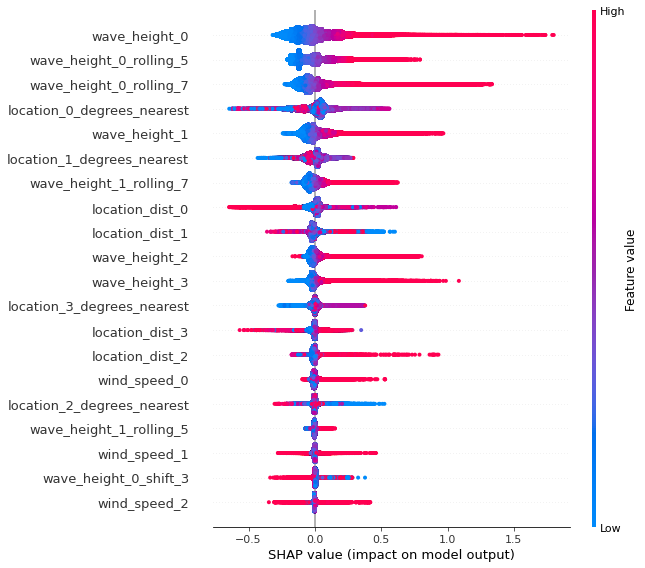

INFO:root:eval set metrics: rmse    0.294717
mae     0.199742
r2      0.800048
dtype: float64


True


INFO:root:Logging SHAP values of eval set predictions...


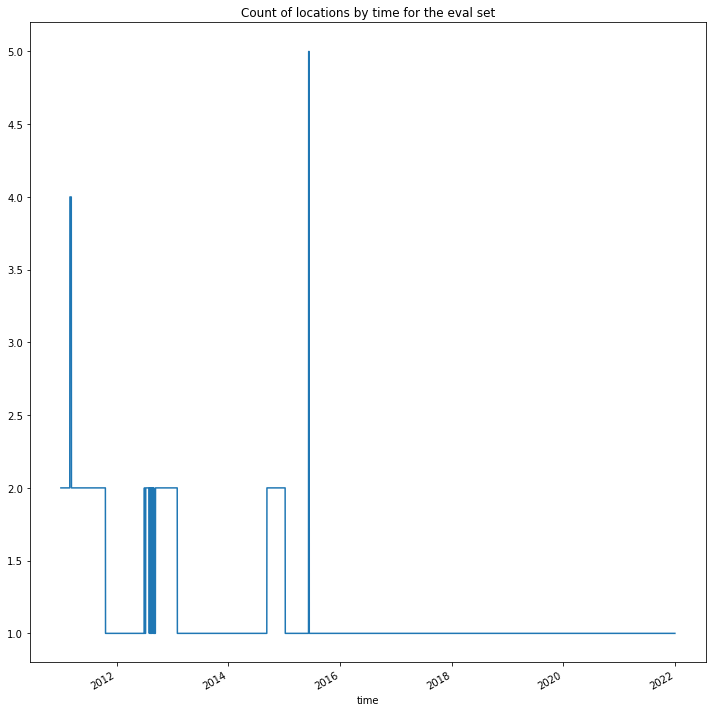

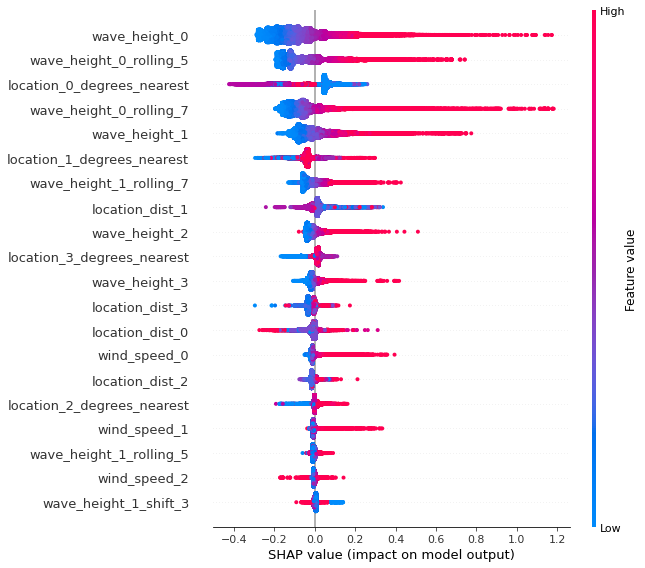

True


INFO:root:Across sets
INFO:root:
         train      eval
rmse  0.370103  0.294717
mae   0.252390  0.199742
r2    0.758015  0.800048
INFO:root:Eval locations and non-eval locations
INFO:root:
         rmse     mae     r2   size
set                                
eval   0.2947  0.1997  0.800  0.057
train  0.3701  0.2524  0.758  0.943
INFO:root:By location id
INFO:root:
               rmse     mae      r2    size  is_eval
location_id                                         
41001        0.5229  0.3657  0.7354  0.0196     True
41002        0.4620  0.3195  0.7448  0.0336    False
41004        0.2730  0.1861  0.8244  0.0390    False
41008        0.2719  0.1946  0.6475  0.0557    False
41009        0.3194  0.2250  0.7620  0.0536    False
41010        0.3416  0.2339  0.8196  0.0429    False
41012        0.2407  0.1676  0.8571  0.0158    False
41013        0.3280  0.2285  0.7567  0.0502    False
41025        0.4264  0.3049  0.6898  0.0340    False
41035        0.2291  0.1664  0.5204  0.0034  

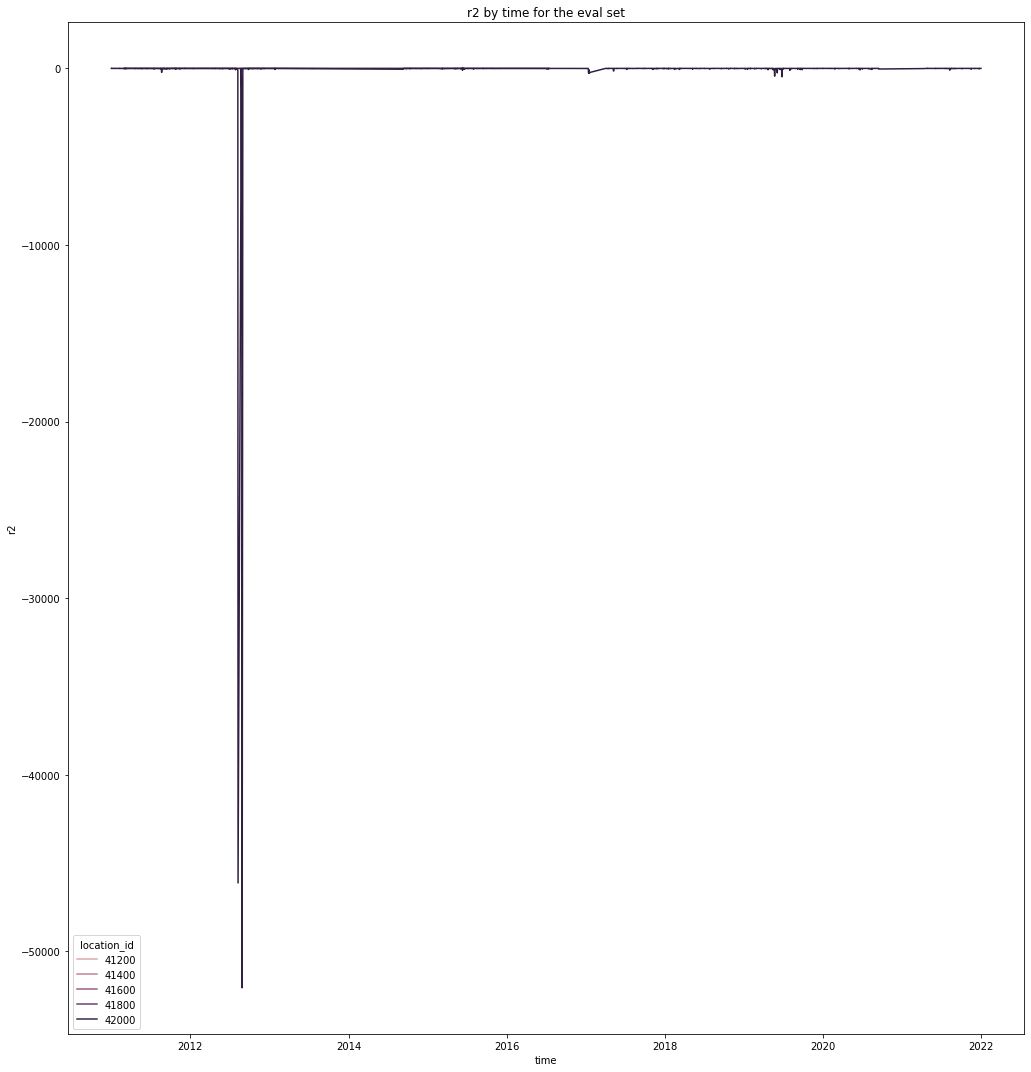

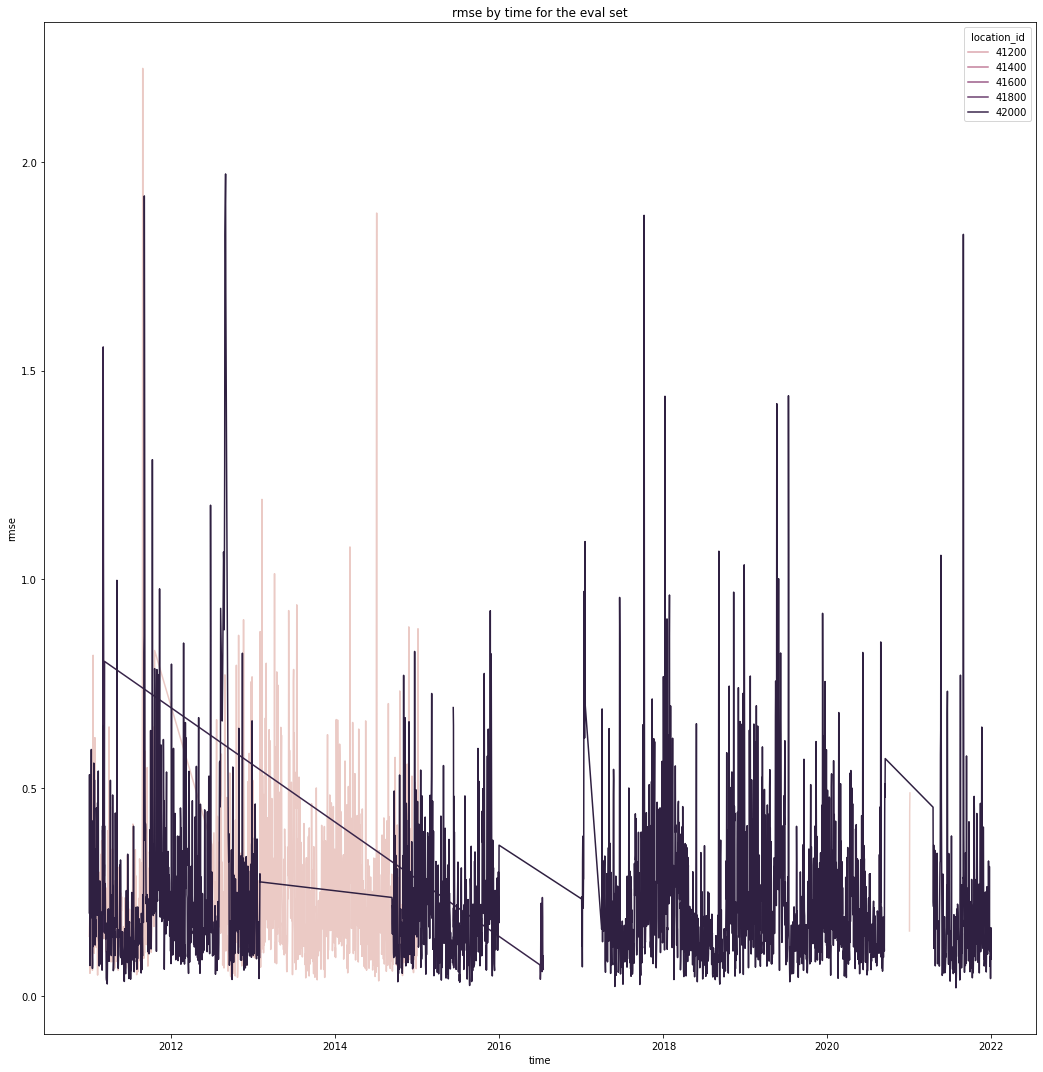

In [82]:
config_name = "experiment2"
experiment = ml_experiments.NOAAMLTraining(config_name, mlflow_tracking_uri=None)
preds_df = experiment.run()

INFO:NOAAMLTraining:Running experiment "NOAA-ML-Interpolation"...
INFO:NOAAMLTraining:Filtering data on time {'end': '2022-01-01', 'start': '2011-01-01'}


Training until validation scores don't improve for 350 rounds
[50]	valid_0's rmse: 0.31273	valid_0's l2: 0.0977997
[100]	valid_0's rmse: 0.30149	valid_0's l2: 0.0908965
[150]	valid_0's rmse: 0.300618	valid_0's l2: 0.0903714
[200]	valid_0's rmse: 0.297924	valid_0's l2: 0.0887585
[250]	valid_0's rmse: 0.296815	valid_0's l2: 0.0880991
[300]	valid_0's rmse: 0.296658	valid_0's l2: 0.0880062
[350]	valid_0's rmse: 0.296159	valid_0's l2: 0.0877103
[400]	valid_0's rmse: 0.295098	valid_0's l2: 0.0870828
[450]	valid_0's rmse: 0.298278	valid_0's l2: 0.08897
[500]	valid_0's rmse: 0.298141	valid_0's l2: 0.0888883
[550]	valid_0's rmse: 0.301232	valid_0's l2: 0.090741
[600]	valid_0's rmse: 0.30487	valid_0's l2: 0.0929457


INFO:NOAAMLTraining:Model was fitted in: 78.55s


[650]	valid_0's rmse: 0.306512	valid_0's l2: 0.0939494
Did not meet early stopping. Best iteration is:
[416]	valid_0's rmse: 0.294612	valid_0's l2: 0.0867961


INFO:NOAAMLTraining:Model fit with score 0.7510
INFO:NOAAMLTraining:Evaluation metrics: {'rmse': 0.29461173587707923, 'r2': 0.8024314034228504}
INFO:root:Computing test and eval metrics...
INFO:root:X_eval shape: (94171, 24)
INFO:root:train set metrics: rmse    0.377203
mae     0.258283
r2      0.751035
dtype: float64
INFO:root:Logging SHAP values of train set predictions...


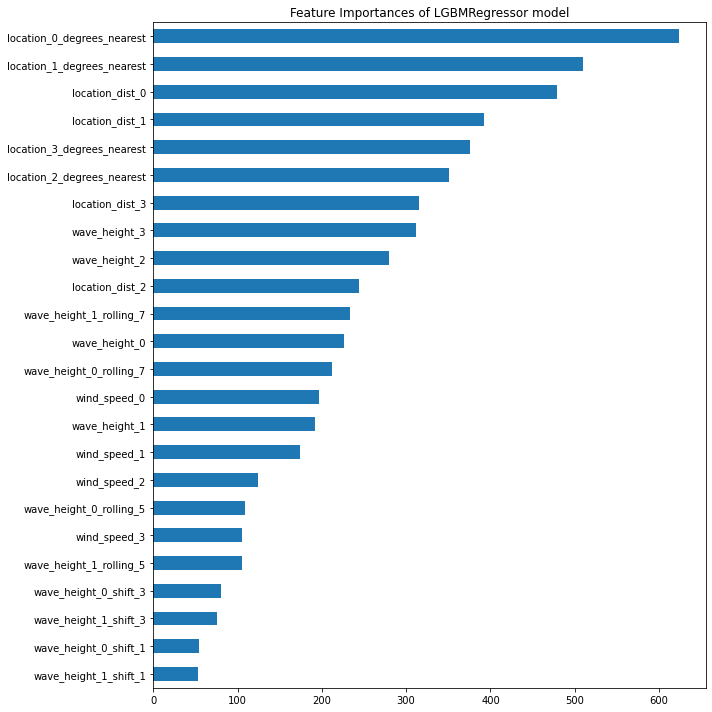

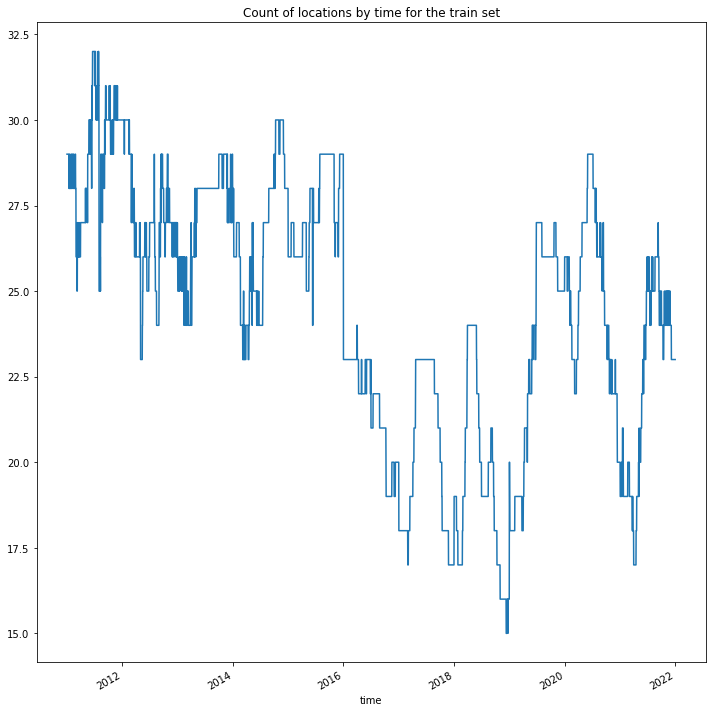

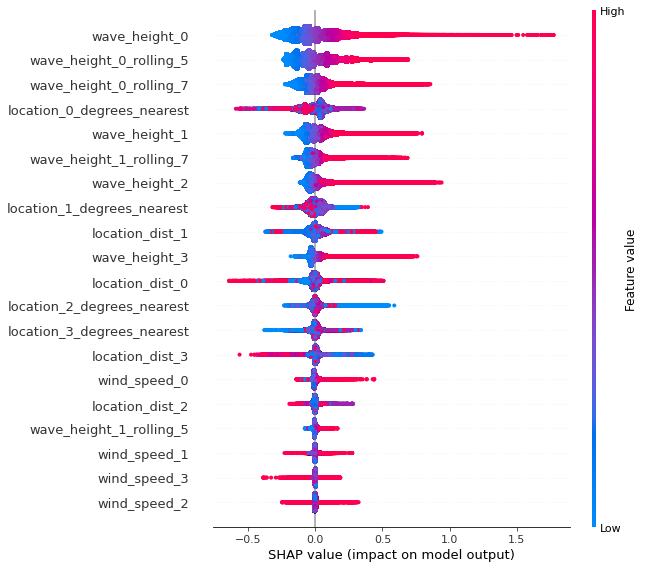

INFO:root:eval set metrics: rmse    0.294612
mae     0.203561
r2      0.802431
dtype: float64


True


INFO:root:Logging SHAP values of eval set predictions...


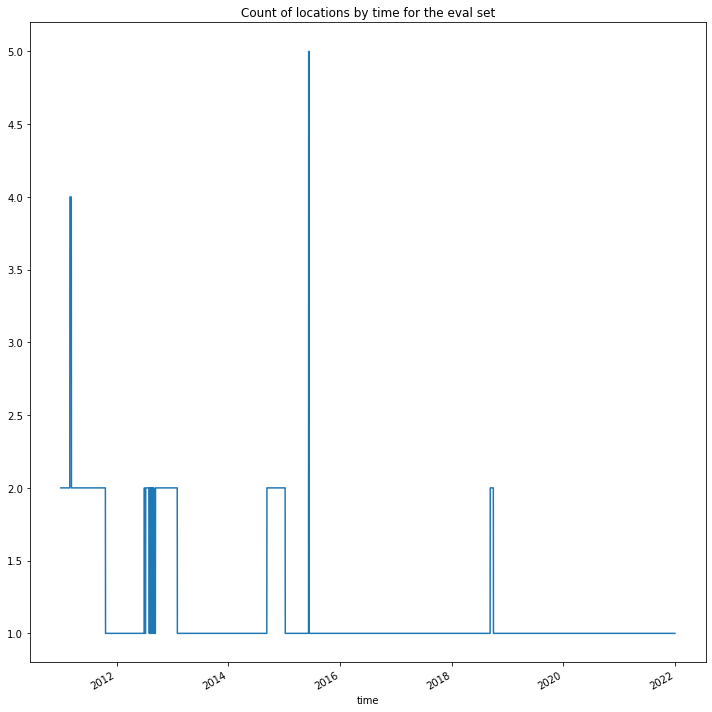

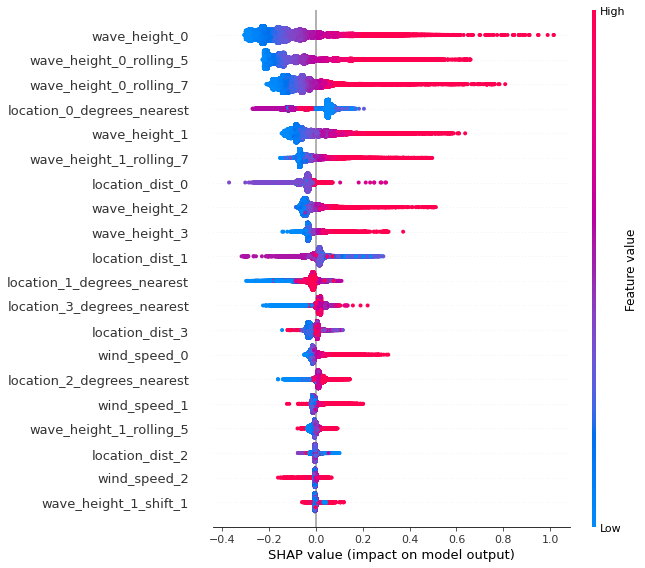

True


INFO:root:Across sets
INFO:root:
         train      eval
rmse  0.377203  0.294612
mae   0.258283  0.203561
r2    0.751035  0.802431
INFO:root:Eval locations and non-eval locations
INFO:root:
         rmse     mae      r2    size
set                                  
eval   0.2946  0.2036  0.8024  0.0393
train  0.3772  0.2583  0.7510  0.9607
INFO:root:By location id
INFO:root:
               rmse     mae      r2    size  is_eval
location_id                                         
41001        0.5511  0.3819  0.7061  0.0135     True
41002        0.4795  0.3287  0.7252  0.0230    False
41004        0.2821  0.1916  0.8124  0.0268    False
41008        0.2798  0.2015  0.6268  0.0382    False
41009        0.3291  0.2315  0.7473  0.0368    False
41010        0.3505  0.2381  0.8101  0.0294    False
41012        0.2506  0.1729  0.8450  0.0108    False
41013        0.3394  0.2356  0.7395  0.0344    False
41025        0.4335  0.3088  0.6795  0.0233    False
41035        0.2545  0.1796  0.4079  

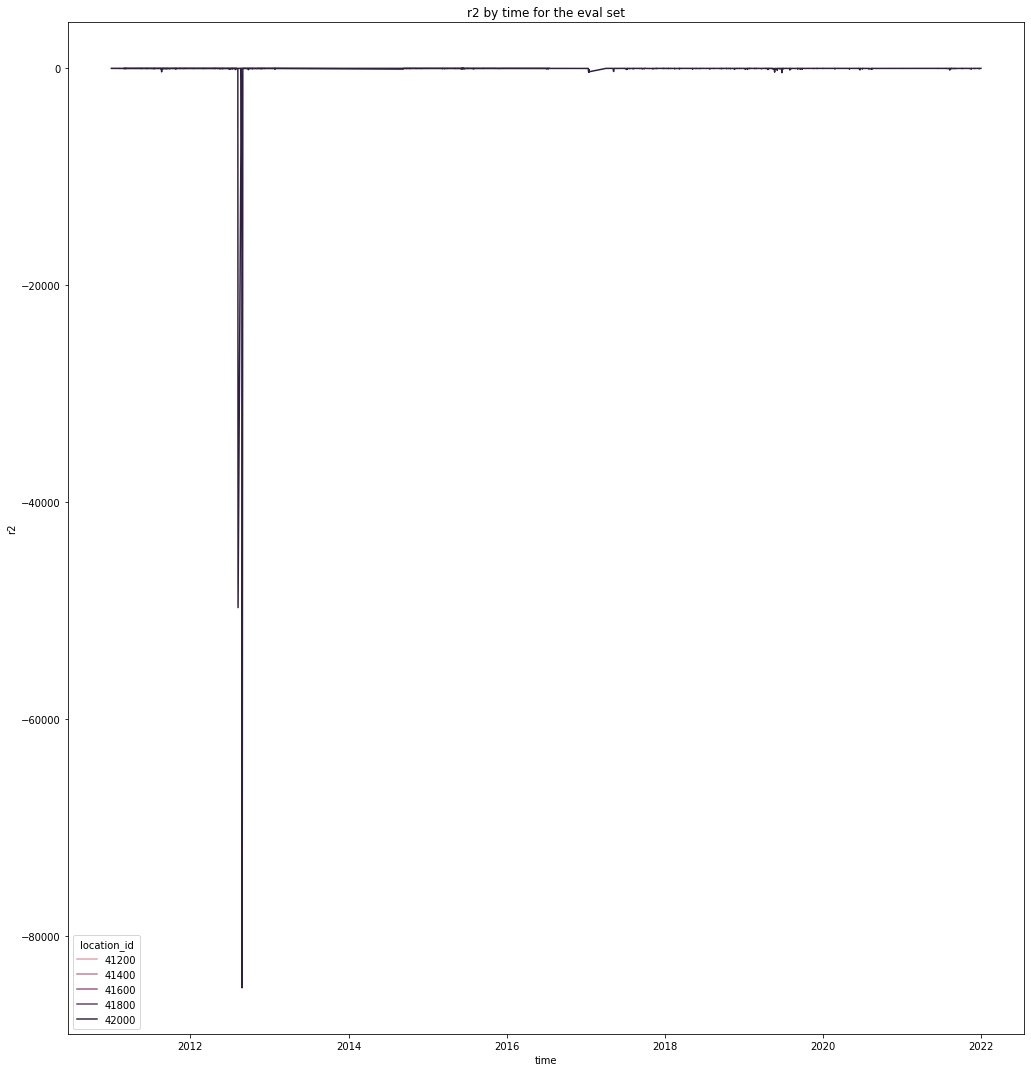

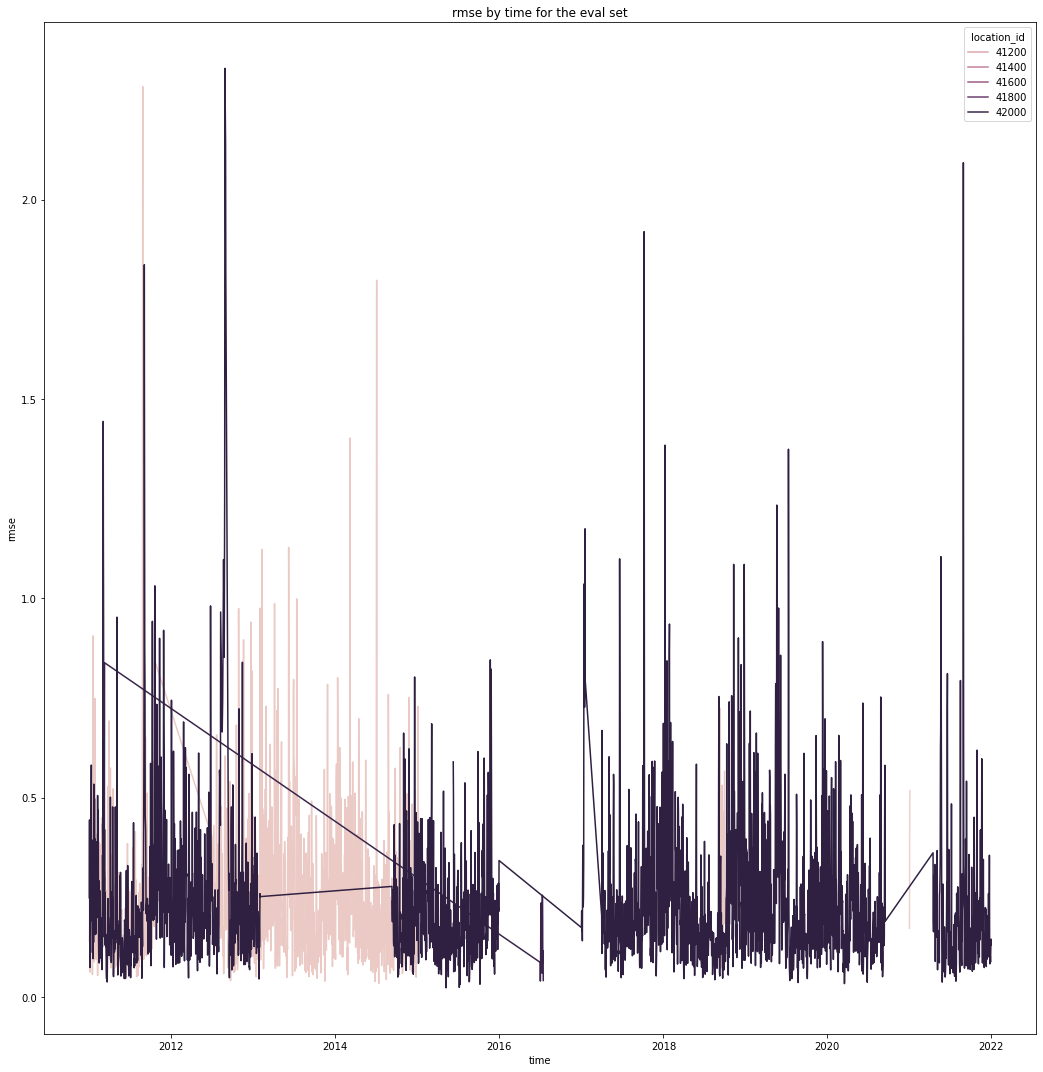

In [83]:
config_name = "experiment3"
experiment = ml_experiments.NOAAMLTraining(config_name, mlflow_tracking_uri=None)
preds_df = experiment.run()

-----

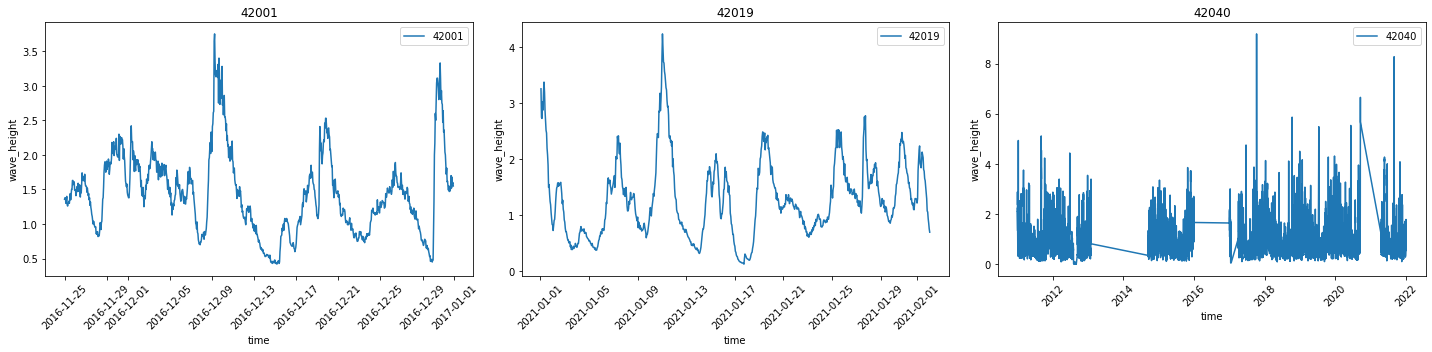

In [74]:
from subplotted import subplotted
locations = y_eval.index.get_level_values("location_id").unique()
for S, ax, location in subplotted(locations, ncols=3, figsize=(20,5)):
    sns.lineplot(data=y_eval.loc[location].reset_index(), x="time", y=y_eval.name, ax=ax, label=location)
    ax.set_title(location)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
else:
    S.fig.tight_layout()

-----

In [20]:
logged_model = 'runs:/ff7f1f66432a427a96ee988461a64a0b/lgbmregressor'
loaded_model = mlflow.pyfunc.load_model(logged_model)

-----

In [ ]:
# Load Experiment Configuration, search and evaluate hyperparameters
conf_loader = ConfigLoader(conf_paths)
parameters = conf_loader.get("parameters*", "parameters*/**")

mod = lgb.LGBMRegressor()
fit_params = dict(
    callbacks=[
        lgb.early_stopping(
            stopping_rounds=350,
            verbose=False
        ),
    ],
    eval_set=[(X_eval, y_eval)],
    eval_metric="rmse",
)

search_params = parameters["gridsearch_params"].get("param_grid", {})

for param in parameters["model_params"]:
    if param not in search_params:
        search_params[param] = [parameters["model_params"][param]]

parameters_to_search = list(ParameterGrid(search_params))

with tqdm_joblib(tqdm(desc="training grid...",total=len(parameters_to_search))) as pbar:
    results = Parallel(n_jobs=30)(
        delayed(fit_estimator_with_params)(mod,X=X_train,y=y_train,params=params,fit_params=fit_params) 
        for params in parameters_to_search
    )

# get best estimator and results
best_estimator = min(results,key=lambda d: d["est_best_score"])["estimator"]
print("Best results:");pprint(min(results,key=lambda d: d["est_best_score"]))
print("Worst results:");pprint(max(results,key=lambda d: d["est_best_score"]))

results_df = pd.DataFrame(results).sort_values("est_best_score",ascending=True)
results_df = pd.concat([results_df,results_df.params.apply(pd.Series)],axis=1)
results_df.index.name = "round"

print(results_df.iloc[0]["params"])

In [ ]:
# show param progression
sns.lineplot(x="n_estimators",y="est_best_score",data=results_df)

In [ ]:
# show metrics of best estimator by evaluation set (train, test, eval)
metrics = {}
for split,y,X in zip(["train","test","eval"],[y_train,y_test,y_eval],[X_train, X_test, X_eval]):
    if len(X)==0: continue
    pred = best_estimator.predict(X)
    split_metrics = compute_metrics(y,pred)
    split_metrics_dict = {
        f"{k}_{split}":[v]
        for k,v in split_metrics.to_dict().items()
    }
    metrics.update(split_metrics_dict)
metrics_df = pd.DataFrame(metrics,index=["score"]).rename_axis("metric").T
display(metrics_df.sort_index())

In [ ]:
# show metrics by buoy
preds = []
for split,y,X in zip(["train","test","eval"],[y_train,y_test,y_eval],[X_train, X_test, X_eval]):
    if len(X)==0: continue
    pred = best_estimator.predict(X)
    split_metrics = compute_metrics(y.values[:,0],pred)
    split_metrics_dict = {
        f"{k}_{split}":[v]
        for k,v in split_metrics.to_dict().items()
    }
    metrics.update(split_metrics_dict)
    y_preds = pd.DataFrame(dict(true=y.values[:,0],pred=pred),index=X.index)
    y_preds["split"] = split
    preds.append(y_preds)
preds_df = pd.concat(preds,axis=0)
preds_df.groupby("buoy_id").apply(
    lambda g: compute_metrics(g.true,g.pred)
).assign(is_eval=lambda df: df.index.isin(y_eval.index.get_level_values(0)))

In [ ]:
# log metrics
mlflow.log_metrics({f"{variable}_best__{row.name}":round(row.score,4) for row in metrics_df.iloc()})

In [ ]:
# log metrics figure
ax = sns.barplot(data=metrics_df.T.round(3))
ax.set(title=f"Best {variable} metrics")
ax.bar_label(ax.containers[0])
fig = ax.get_figure();
mlflow.log_figure(fig,f"{variable}_best_metrics.png")

In [ ]:
# log the shap values
shap_values = shap.TreeExplainer(best_estimator).shap_values(X_eval)
fig, ax = plt.subplots(figsize=(18,15),facecolor="white")
shap.summary_plot(shap_values, X_eval)
plt.tight_layout(); fig.set_figwidth(18)
mlflow.log_figure(fig,f"{variable}_shap_summary.png")

In [ ]:
# train model with the best parameter on all data
X = pd.concat([X_train,X_eval],axis=0)
y = pd.concat([y_train,y_eval],axis=0)
mod.set_params(**best_estimator.get_params()) # parameters["model_params"]
mod.fit(X,y,**fit_params)
mod

In [ ]:
# pickle the model and log it to the experiment run
model_fname = f"data/06_models/best_lightgbm_model_{variable}.pkl"
pickle.dump(mod, open(model_fname,"wb"))
print(f"Saved model to {model_fname}")
mlflow.sklearn.log_model(best_estimator,f"{variable}_best_model")

In [ ]:
# register the model
run_id = mlflow.last_active_run().info.run_id
model_uri = f"runs:/{run_id}/{variable}_best_model"
mlflow.register_model(model_uri,name=f"{variable}_lightgbm_model_v1")

In [ ]:
# end experiment run
mlflow.end_run()